# Data Science & Business Analytics Intern at The Sparks Foundation - GRIP APRIL'21 Batch
### Author: Sumit Mishra

##  TASK 3: Social Distancing detector (Domain: Computer Vision & Internet of Things)

### Implement a real time Social Distancing detector which can identify the distance between two individuals in a crowd. 

### 1. Importing the required header files

In [1]:
#importing the required packages
import numpy as np
import imutils
import cv2
import os
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow
from google.colab import files

### 2. What is Social Distancing?

> * Social distancing is a method used to control the spread of contagious diseases or viruses such as Covid-19.
> * As the name suggests, social distancing implies that people should maintain physically distance from one another, reducing close contact, and thereby reducing the spread of a contagious disease (such as Covid-19).

### 3. Need of Social Distancing detection system

* Even after the strict guidelines given by Government, many peoples are not following the guidelines such as wearing a mask, maintaining social distance from one another, etc.
* That is one of the main reasons for the Covid-19 virus spread.
* So these types of systems are very useful, especially now in the second phase of covid-19.
* In my previous post, I explained how to build a face mask detection system.
* Now, I'll explain how to build our own social distancing detection system.
* These type of system are very useful and can be installed on offices to check whether employees are following covid-19 guidelines or not and many places like this.

### 4. First Cut Solution

* To build this system we'll be using pre-trained yolo model for object detection and our own distance calculator to find that people are following social distancing or not.
* With the help of yolo model, we'll detect person in a frame/image.
* Then we'll find the distance between peoples by setting some threshold value(i.e. minimum social distance value).
* To do so there are multiple ways such as finding distance between peoples in pixel by using metrics such as euclidean distance or we can build one more model that finds the distance between objects in units like meter or feet.
* For our system, I'll use combination of both approaches.
* First I'll find the center of the person's bounding box and then I'll find the distance between 2 persons using height of that bouding box.
* For example, each bounding box will have height and width and I think as camera calibration point the farther objects will have less pixel distance and nearer objects will have more pixel distance if we try to map pixel distance as meter distance or any other units.
* So, the minimum threshold value will be based on the height of the detected persons. Because on an average each person has height of 5-6 feet which is approximately 2 meters.

### 5. People detection

In [ ]:
def detect_people(frame, yolo_model, yolo_output_layer):
  '''
  This function accepts the frame of video stream or an image, yolo model and output layer of yolo model
  and returns the person prediction probability, bounding box coordinates, and the centroid.
  '''
  #Getting height and width of frame
  (H, W) = frame.shape[:2]
  results = []

	#Construct a blob from the input frame and forwarding pass of the YOLO object detector
  #and it returns bounding boxes and associated probabilities
  blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  yolo_model.setInput(blob)
  layerOutputs = yolo_model.forward(yolo_output_layer)
	# initialize our lists of detected bounding boxes, centroids, and
	# confidences, respectively
  boxes, centroids, confidences = [], [], []

	#Looping over each of the layer outputs
  for output in layerOutputs:
		#Looping over each of the detections
    for detection in output:
			#Getting classID and its confidencescore of the current object detection
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]
			#Picking onl person object from detection which has confidence score more than 35%
      if classID == 0 and confidence > 0.35:
				#Scaling the bounding box coordinates back relative to the size of the image
        #because YOLO only returns the center (x, y) coordinates of the bounding box
        #followed by the boxes width and height
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")
				#Using the center (x, y) coordinates to derive the top and left corner of the bounding box
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
				#Updating list of bounding box coordinates, centroids, and confidences
        boxes.append([x, y, int(width), int(height)])
        centroids.append((centerX, centerY))
        confidences.append(float(confidence))
    
	#Applying non-maxima suppression to suppress weak, overlapping bounding boxes
  ids = cv2.dnn.NMSBoxes(boxes, confidences, 0.35, 0.35)
	#If at least one detection exists then only store results
  if len(ids) > 0:
    for i in ids.flatten():
			#Extracting the bounding box coordinates
      (x, y) = (boxes[i][0], boxes[i][1])
      (w, h) = (boxes[i][2], boxes[i][3])
			#Storing person prediction probability, bounding box coordinates, and the centroid
      r = (confidences[i], (x, y, x + w, y + h), centroids[i])
      results.append(r)

  return results

### 6. Loading YOLO model, its weights and COCO class labels

In [ ]:
#Loading YOLO weights

#!wget https://pjreddie.com/media/files/yolov3.weights

In [ ]:
#Loading the COCO class labels
labels = open("/content/coco.names").read().strip().split("\n")

#Loading YOLO object detector trained on COCO dataset with 80 classes
yolo_model = cv2.dnn.readNetFromDarknet("/content/yolov3.cfg", "/content/yolov3.weights")
 
#Picking only the output layer names that we need from YOLO
yolo_output_layer = yolo_model.getLayerNames()
yolo_output_layer = [yolo_output_layer[i[0] - 1] for i in yolo_model.getUnconnectedOutLayers()]

### 7. Social distancing violations detector

In [ ]:
def detect_violation(frame, yolo_model, yolo_output_layer):
  '''
  This function accepts the frame of video stream or an image, yolo model and output layer of yolo model
  and returns frame/image with no. of violations and bounding box on frame who violated guidelines.
  '''
  #Variable which will store social distancing violations record
  violate = set() #Using set to avoid duplicate entry(i.e. only one entry for each person)
  #Detecting the person in a frame.
  res = detect_people(frame, yolo_model, yolo_output_layer)
  #Checking whether more than 2 peoples are detected or not
  if len(res) >= 2:
		#Extracting all centroids from the results and computing the Euclidean distances
    #between all pairs of the centroids.
    centroids = np.array([r[2] for r in res])
    D = dist.cdist(centroids, centroids, metric="euclidean")

    #Calculating the minimum distance between people according to camera calibration point of view
    #for each pairs of detected person
    min=[]
    for (i, (prob, bbox, centroid)) in enumerate(res):
      temp=[]
      for (j, (prob, bbox, centroid)) in enumerate(res):
        (startX, startY, endX, endY) = bbox
        diff = np.abs(startY-endY)
        temp.append(diff)
      min.append(temp)
    min = np.array(min)
    
    # loop over the upper triangular of the distance matrix
    for i in range(0, D.shape[0]):
      for j in range(i + 1, D.shape[1]):
				#Checking whether distance between any two centroid pairs is less than the minimum distance
        if D[i, j] < min[i, j]:
					#Updating our violation set with the indexes of the centroid pairs
          violate.add(i)
          violate.add(j)


	# loop over the results
  for (i, (prob, bbox, centroid)) in enumerate(res):
		#Extracting the bounding box and centroid coordinates
    (startX, startY, endX, endY) = bbox
    (cX, cY) = centroid
    color = (0, 255, 0) #Green for person who followed social distancing
		#If the index pair exists within the violation set, then updating the color as red
    if i in violate:
      color = (0, 0, 255) #Red for person who didn't followed social distancing
		#Drawing a bounding box around the person.
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
  
  #Putting text which shows number of violators in a frame
  text = "Social Distancing Violations: {}".format(len(violate))
  cv2.putText(frame, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 3)

  return frame #returning the frame

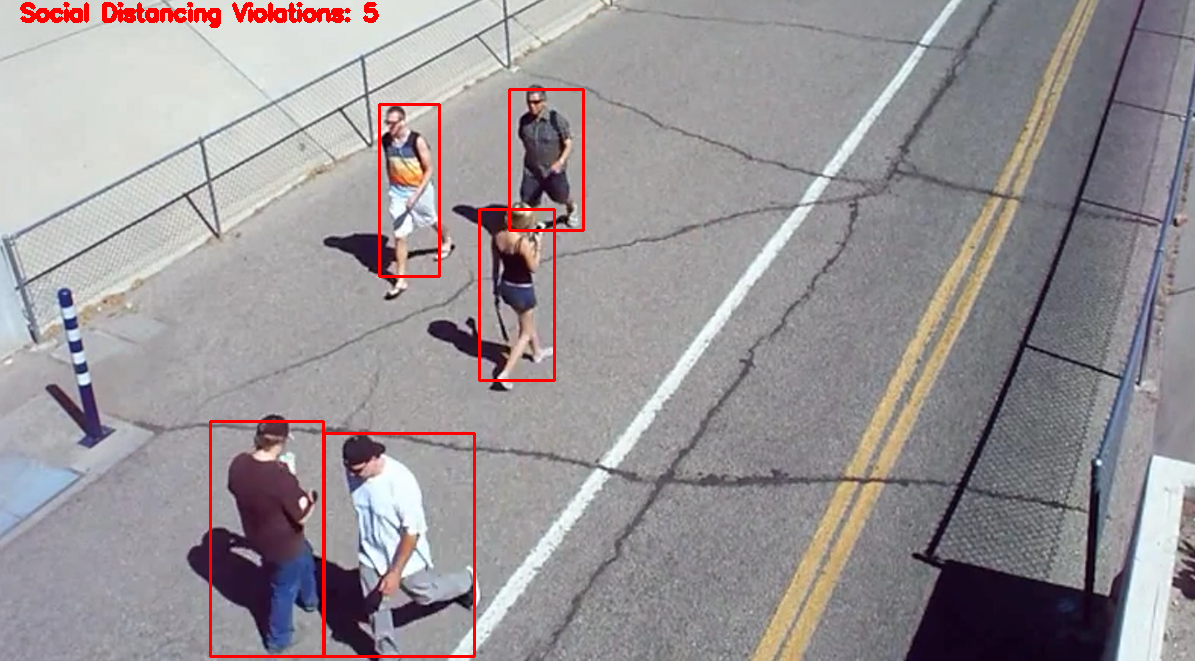

In [ ]:
#Checking social distancing detction system in an image
cv2_imshow(detect_violation(cv2.imread('/content/Capture.PNG'),yolo_model, yolo_output_layer))

* As we can see, our social distance detction system is able to find the violations in an image.
* This can be further extended to detect violations in video stream.

### 8. Social distancing detection in video stream

In [ ]:
def detect_social_distancing_violations():
  '''
  This function ask user to upload a video.
  Then each frames from that video are fetched and passed to detect_violation()
  which will detect whether person is maintaining social distance or not.
  Then each detected frames are merged to create an output video.
  '''
  #Uploading a video(input)
  uploaded = files.upload()
  ext = list(uploaded.keys())[0].split('.')[-1]
  if ext not in ['avi','mp4','AVI','MP4']:
    print('Not a video! Please upload only video files.\n(Only avi and mp4 files are allowed.)')
  else:
    video_path = list(uploaded.keys())[0]
    print('Video uploaded successfully!!!')

  #Reading the video and creating image frames
  cam = cv2.VideoCapture(video_path)
  frames = []
  while(True):
	  #Reading from frame
	  ret,frame = cam.read()
	  if ret:
		  # writing the extracted images
		  frames.append(frame)
	  else:
		  break
  #Releasing all space and windows once done
  cam.release()
  cv2.destroyAllWindows()

  #Detecting social distancing violations for each frames of input video
  op_vid = []
  for i in frames:
    op_vid.append(detect_violation(i,yolo_model, yolo_output_layer))

  #Writing frames to video
  out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (frames[0].shape[1],frames[0].shape[0]))
  for i in range(len(op_vid)):
      out.write(op_vid[i])
  out.release()

  print('Social distancing detection system output video got saved as output.mp4 successfully!!!')

In [2]:
#Testing detect_social_distancing_violations() with video input
#Video input is taken from Kaggle Task: https://www.kaggle.com/jayitabhattacharyya/social-distance
detect_social_distancing_violations()

Saving pedestrian.mp4 to pedestrian.mp4
Video uploaded successfully!!!
Social distancing detection system output video got saved as output.mp4 successfully!!!


### 9. Conclusion

* We have used pre-trained YOLO object detection model to detect person in an image.
* Then we did our own implementation to find the distance between persons.
* We are able to get quite good results as shown testing on images and video stream.
* We implemented our own social distance detection system which works with both images and video streams.
* Now we can say, we have successfully built a model for social distancing detection from an image or a video. 